In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DNN_project
!ls

/content/drive/MyDrive/DNN_project
 config.yaml		     experiments.ipynb	 requirements.txt   src
'experiments - Copy.ipynb'   Readme.md		 results


In [ ]:
!pip install datasets
!pip install transformers
!pip install ipywidgets
!pip install rouge-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=db6221db2cb7f17010f42d729d5b349be46f19be80fe643210bbe6ae0ead0418
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
import sys
import os

PROJECT_ROOT = os.getcwd()
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

from src.train import train, greedy_decode
from src.utils import (
    load_config,
    prepare_dataset,
    make_tf_dataset,
    distinct_n,
    compute_bleu,
    compute_meteor
)
from src.model import build_multimodal_model

In [ ]:
cfg = load_config("config.yaml")
print(cfg)

{'dataset': {'hf_name': 'daniel3303/StoryReasoning', 'seq_len': 3, 'batch_size': 8, 'image_size': 128, 'max_caption_len': 16}, 'model': {'image_feat_dim': 512, 'text_embed_dim': 300, 'text_hidden_dim': 512, 'multimodal_dim': 512, 'temporal_hidden_dim': 512, 'text_decoder_hidden': 512, 'vocab_size': 30522, 'pad_token_id': 0, 'bos_token_id': 101, 'eos_token_id': 102}, 'training': {'lr': '1e-4', 'epochs': 5, 'device': 'auto', 'grad_clip': 1.0, 'log_interval': 50, 'save_dir': 'results/checkpoints'}}


In [ ]:
import sys
if 'src.train' in sys.modules:
    del sys.modules['src.train']

from src.train import train

model, models, tokenizer = train(cfg, keep_small=True)

Loading training dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Training examples: 64
Loading validation dataset...
Validation examples: 64

Epoch 1/5


loss=0.0003 text=0.0000 img=0.0006: : 3it [00:40, 13.66s/it]


Saved checkpoint: results/checkpoints/ckpt_epoch1.weights.h5
[Validation] Dist-1=0.2453 Dist-2=0.3265 BLEU=0.0000 METEOR=0.0000

Epoch 2/5


loss=0.0007 text=0.0000 img=0.0014: : 3it [00:40, 13.65s/it]


Saved checkpoint: results/checkpoints/ckpt_epoch2.weights.h5
[Validation] Dist-1=0.3627 Dist-2=0.4787 BLEU=0.0000 METEOR=0.0000

Epoch 3/5


loss=0.0014 text=0.0000 img=0.0027: : 3it [00:33, 11.01s/it]


Saved checkpoint: results/checkpoints/ckpt_epoch3.weights.h5
[Validation] Dist-1=0.2407 Dist-2=0.3800 BLEU=0.0000 METEOR=0.0000

Epoch 4/5


loss=0.0023 text=0.0000 img=0.0046: : 3it [00:40, 13.65s/it]


Saved checkpoint: results/checkpoints/ckpt_epoch4.weights.h5
[Validation] Dist-1=0.1273 Dist-2=0.1863 BLEU=0.0000 METEOR=0.0000

Epoch 5/5


loss=0.0035 text=0.0000 img=0.0069: : 3it [00:31, 10.49s/it]


Saved checkpoint: results/checkpoints/ckpt_epoch5.weights.h5
[Validation] Dist-1=0.1373 Dist-2=0.2234 BLEU=0.0000 METEOR=0.0000

Training complete.


In [ ]:
val_processed, _ = prepare_dataset(cfg, split="test", keep_small=True)
val_ds = make_tf_dataset(val_processed, cfg, shuffle=False)

In [ ]:
all_preds, all_refs = [], []

for images_batch, input_ids_batch in tqdm(val_ds):
    images = images_batch.numpy()
    captions_seq = input_ids_batch.numpy()

    pred_ids = greedy_decode(model, images, captions_seq, cfg)

    for i in range(pred_ids.shape[0]):
        pred_text = tokenizer.decode(pred_ids[i], skip_special_tokens=True)
        ref_text = tokenizer.decode(captions_seq[i, -1], skip_special_tokens=True)
        all_preds.append(pred_text)
        all_refs.append(ref_text)

8it [04:21, 32.74s/it]


In [ ]:
dist1 = distinct_n(all_preds, 1)
dist2 = distinct_n(all_preds, 2)
bleu = np.mean([compute_bleu(r, p) for r, p in zip(all_refs, all_preds)])
meteor = np.mean([compute_meteor(r, p) for r, p in zip(all_refs, all_preds)])

print("FINAL METRICS")
print(f"Distinct-1: {dist1:.4f}")
print(f"Distinct-2: {dist2:.4f}")
print(f"BLEU: {bleu:.4f}")
print(f"METEOR: {meteor:.4f}")

FINAL METRICS
Distinct-1: 0.0230
Distinct-2: 0.0473
BLEU: 0.0000
METEOR: 0.0000


In [ ]:
results = {
    "Distinct-1": dist1,
    "Distinct-2": dist2,
    "BLEU": bleu,
    "METEOR": meteor
}

os.makedirs("results", exist_ok=True)

with open("results/final_metrics.json", "w") as f:
    json.dump(results, f, indent=2)

results

{'Distinct-1': 0.02303030303030303,
 'Distinct-2': 0.04730617608409987,
 'BLEU': np.float64(0.0),
 'METEOR': np.float64(0.0)}

In [ ]:
for i in range(5):
    print(f"\nExample {i+1}")
    print("GT:", all_refs[i])
    print("PR:", all_preds[i])


Example 1
GT: 
PR: suicidal towards towards untouched towards formally resemblance resembling nino resemblingbution nino agreed nino terraces

Example 2
GT: 
PR: suicidal towards towards untouched towards formally resemblance resembling resembling ninobution nino agreedolsols

Example 3
GT: 
PR: suicidal towards towards untouched towards formally resemblance resembling nino resemblingbution nino agreed nino terraces

Example 4
GT: 
PR: suicidal towards towards untouched towards formally resemblance resembling nino resemblingbution nino agreed nino terraces

Example 5
GT: 
PR: suicidal towards towards untouched towards formally resemblance resembling resembling ninobution nino agreedolsial


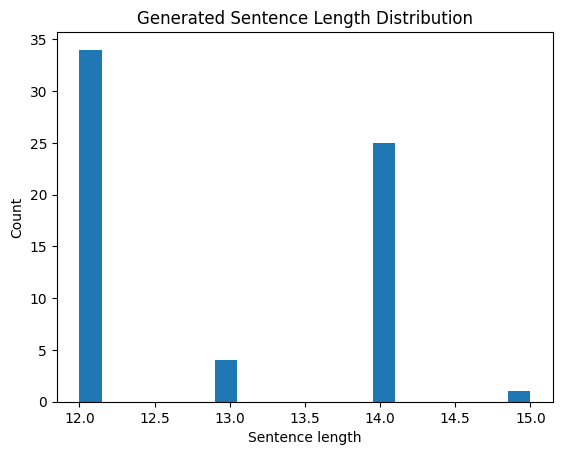

In [ ]:
lengths = [len(p.split()) for p in all_preds]

plt.hist(lengths, bins=20)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("Generated Sentence Length Distribution")
plt.show()

In [ ]:
def visualize_story_prediction(model, example, tokenizer, cfg):
    images = example["images"]
    input_ids = example["input_ids"]

    pred_ids = greedy_decode(
        model,
        images[np.newaxis, ...],
        input_ids[np.newaxis, ...],
        cfg
    )[0]

    pred_text = tokenizer.decode(pred_ids, skip_special_tokens=True)

    pad_id = cfg['model']['pad_token_id']
    gt_ids = [int(x) for x in input_ids[-1] if int(x) != pad_id]
    gt_text = tokenizer.decode(gt_ids, skip_special_tokens=True)

    seq_len = images.shape[0]
    fig, axes = plt.subplots(1, seq_len, figsize=(4 * seq_len, 4))

    if seq_len == 1:
        axes = [axes]

    for i in range(seq_len):
        img = images[i]
        img = (img / 2.0) + 0.5
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].axis("off")
        axes[i].set_title(f"Frame {i+1}")

    plt.show()

    print("🟩 Ground Truth Story:")
    print(gt_text)
    print("\n🟦 Predicted Story:")
    print(pred_text)


=Example 1 =



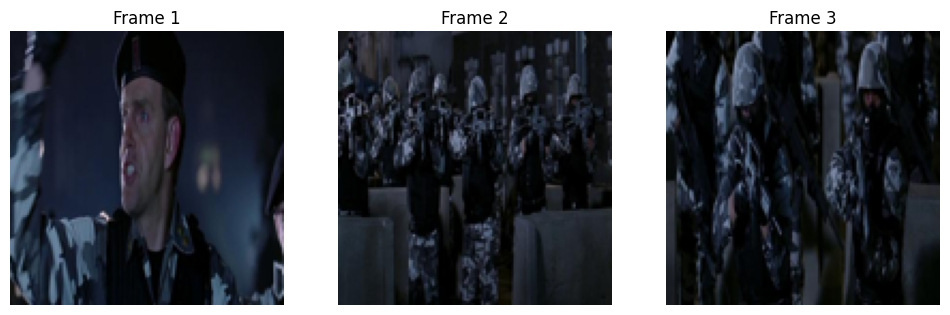

🟩 Ground Truth Story:


🟦 Predicted Story:
suicidal towards towards untouched towards formally resemblance resembling nino resemblingbution nino agreed nino terraces

=Example 2 =



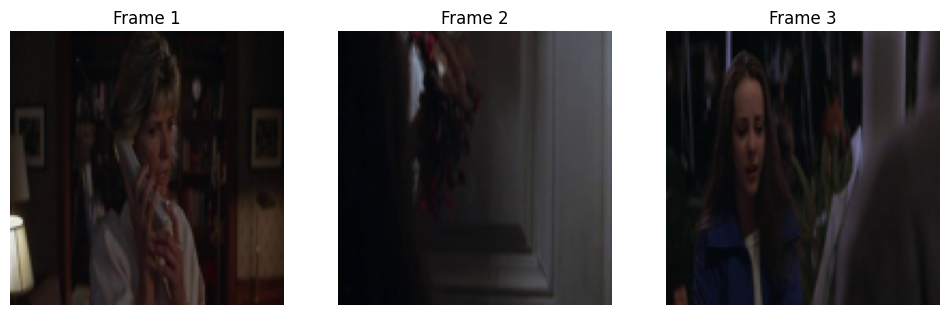

🟩 Ground Truth Story:


🟦 Predicted Story:
suicidal towards towards untouched towards formally resemblance resembling resembling ninobution nino agreedolsols

=Example 3 =



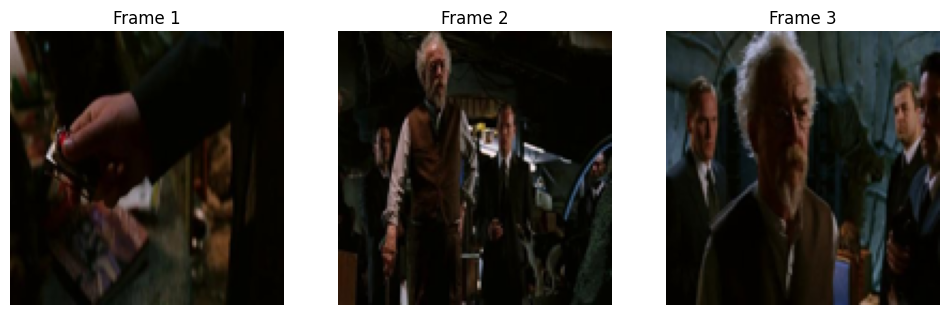

🟩 Ground Truth Story:


🟦 Predicted Story:
suicidal towards towards untouched towards formally resemblance resembling nino resemblingbution nino agreed nino terraces


In [ ]:
processed_val, tokenizer = prepare_dataset(cfg, split="test", keep_small=True)

for i in range(3):
    print(f"\n=Example {i+1} =\n")
    visualize_story_prediction(model, processed_val[i], tokenizer, cfg)